In [11]:
import os
import sys
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.feature_selection import GenericUnivariateSelect, RFE
from sklearn import metrics
from sklearn import linear_model, decomposition, datasets
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression
import seaborn as sns # More snazzy plotting library
import itertools
from itertools import  product
import pprint
from sklearn.ensemble import ExtraTreesRegressor
from multiprocessing import Process, Value, Array
from asyncio import Queue
from threading import Thread
import pickle
import shutil
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import r2_score

path_full = "../dataset/no_imdb_names-count_cat-tf_184f.csv"
path_train = "../dataset/no_imdb_names-count_cat-tf_184f_train.csv"
path_test = "../dataset/no_imdb_names-count_cat-tf_184f_test.csv"

dta_full = pd.read_csv(path_full)
dta_full = dta_full.fillna(value=0, axis=1)
dta_full = dta_full.dropna()
dta_full = dta_full.drop('Unnamed: 0', axis=1)

dta_train = pd.read_csv(path_train)
dta_train = dta_train.fillna(value=0, axis=1)
dta_train = dta_train.dropna()
dta_train = dta_train.drop('Unnamed: 0', axis=1)

dta_test = pd.read_csv(path_test)
dta_test = dta_test.fillna(value=0, axis=1)
dta_test = dta_test.dropna()
dta_test = dta_test.drop('Unnamed: 0', axis=1)

def label_gross_2 (gross):
    if (gross < 200000000) : return 1
    elif (gross >= 200000000) : return 2

def label_gross_3 (gross):
    if (gross < 10000000) : return 1
    elif ((gross >= 10000000) & (gross < 300000000)) : return 2
    elif (gross >= 300000000) : return 3

def label_gross_4 (gross):
    if (gross < 5000000) : return 1
    elif ((gross >= 5000000) & (gross < 50000000)) : return 2
    elif ((gross >= 50000000) & (gross < 350000000)) : return 3
    elif (gross >= 350000000) : return 4

def label_gross_5 (gross):
    if (gross < 1000000) : return 1
    elif ((gross >= 1000000) & (gross < 25000000)) : return 2
    elif ((gross >= 25000000) & (gross < 100000000)) : return 3
    elif ((gross >= 100000000) & (gross < 400000000)) : return 4
    elif (gross >= 400000000) : return 5
    
def label_gross_6 (gross):
    if (gross < 1000000) : return 1
    elif ((gross >= 1000000) & (gross < 25000000)) : return 2
    elif ((gross >= 25000000) & (gross < 50000000)) : return 3
    elif ((gross >= 50000000) & (gross < 150000000)) : return 4
    elif ((gross >= 150000000) & (gross < 450000000)) : return 5
    elif (gross >= 450000000) : return 6

def label_gross_7 (gross):
    if (gross < 500000) : return 1
    elif ((gross >= 500000) & (gross < 5000000)) : return 2
    elif ((gross >= 5000000) & (gross < 50000000)) : return 3
    elif ((gross >= 50000000) & (gross < 150000000)) : return 4
    elif ((gross >= 150000000) & (gross < 200000000)) : return 5
    elif ((gross >= 200000000) & (gross < 500000000)) : return 6
    elif (gross >= 500000000) : return 7
    
def label_gross_8 (gross):
    if (gross < 500000) : return 1
    elif ((gross >= 500000) & (gross < 5000000)) : return 2
    elif ((gross >= 5000000) & (gross < 20000000)) : return 3
    elif ((gross >= 20000000) & (gross < 50000000)) : return 4
    elif ((gross >= 50000000) & (gross < 100000000)) : return 5
    elif ((gross >= 100000000) & (gross < 250000000)) : return 6
    elif ((gross >= 250000000) & (gross < 550000000)) : return 7
    elif (gross >= 550000000) : return 8

def label_gross_9 (gross):
    if (gross < 500000) : return 1
    elif ((gross >= 500000) & (gross < 5000000)) : return 2
    elif ((gross >= 5000000) & (gross < 20000000)) : return 3
    elif ((gross >= 20000000) & (gross < 50000000)) : return 4
    elif ((gross >= 50000000) & (gross < 70000000)) : return 5
    elif ((gross >= 70000000) & (gross < 125000000)) : return 6
    elif ((gross >= 125000000) & (gross < 250000000)) : return 7
    elif ((gross >= 250000000) & (gross < 550000000)) : return 8
    elif (gross >= 550000000) : return 9
    
def label_gross_10 (gross):
    if    (gross  < 500000) : return 1
    elif ((gross >= 500000)    & (gross < 5000000)) : return 2
    elif ((gross >= 5000000)   & (gross < 20000000)) : return 3
    elif ((gross >= 20000000)  & (gross < 50000000)) : return 4
    elif ((gross >= 50000000)  & (gross < 70000000)) : return 5
    elif ((gross >= 70000000)  & (gross < 125000000)) : return 6
    elif ((gross >= 125000000) & (gross < 250000000)) : return 7
    elif ((gross >= 250000000) & (gross < 400000000)) : return 8
    elif ((gross >= 400000000) & (gross < 600000000)) : return 9
    elif  (gross >= 600000000) : return 10
    
pw = 4
def log_poly(X):
    #hardcoe for this test
    global pw
    #do log
    df_t = pd.DataFrame(X[:,:10])
    X_t = df_t.replace(0, 1/math.e)
    log_res = np.log(X_t)
    
    #do poly
    vector = X[:,10:]
    res    = X[:,:10]
    X      = X[:,:10]
    for power in range(2,pw + 1):
        res = np.concatenate((res, np.power(X, power)), axis=1)
    res_poly_log = np.concatenate((res, log_res), axis=1)
    
    #return conat results
    return np.concatenate((res_poly_log, vector), axis=1)

LogPolynomialTransformer = FunctionTransformer(log_poly)

preprocessor = LogPolynomialTransformer

transfomer = StandardScaler()

reducer = RFE(ExtraTreesRegressor(), step=0.1, n_features_to_select =round((dta_train.shape[1] + (pw -1) *10)*0.33) )

model_class = GradientBoostingClassifier()
model_reg = GradientBoostingRegressor()

pipe_cl = Pipeline(steps=[('preprocessor', preprocessor), ('transfomer', transfomer), ('reducer', reducer),  ('classifier', model_class)])
pipe_reg = Pipeline(steps=[('preprocessor', preprocessor), ('transfomer', transfomer), ('reducer', reducer),  ('classifier', model_reg)])

x_train = dta_train.drop('worldwide_gross', axis=1)
y_train_cl = dta_train.worldwide_gross.apply (lambda gross: label_gross_3 (gross))
y_train_reg = dta_train['worldwide_gross']

x_test = dta_test.drop('worldwide_gross', axis=1)
y_test_cl = dta_test.worldwide_gross.apply (lambda gross: label_gross_3 (gross))
y_test_reg = dta_test['worldwide_gross']

scores_cl = cross_val_score(pipe_cl ,x_train, y_train_cl, cv=5)
scores_reg = cross_val_score(pipe_reg ,x_train, y_train_reg, cv=5)
print(scores_cl)
print(scores_reg)


[ 0.77572559  0.7651715   0.75593668  0.75231788  0.78145695]
[ 0.58961695  0.63759829  0.60571981  0.49291013  0.5466911 ]


In [2]:
model_test_cl =  pipe_cl.fit(x_train, y_train_cl)
model_test_reg =  pipe_reg.fit(x_train, y_train_reg)
print(model_test_cl.score(x_train,y_train_cl))
print(model_test_reg.score(x_train,y_train_reg))

0.458509513742
0.75096597253


In [3]:
print(model_test_cl.score(x_test,y_test_cl))
print(model_test_reg.score(x_test,y_test_reg))

0.421330517423
0.640583692201


In [4]:
model_test_grtb_cl =  GradientBoostingClassifier().fit(x_train, y_train_cl)
print(model_test_grtb_cl.score(x_train,y_train_cl))
print(model_test_grtb_cl.score(x_test,y_test_cl))

0.82822410148
0.794086589229


In [5]:
model_test_grtb_reg =  GradientBoostingRegressor().fit(x_train, y_train_reg)
print(model_test_grtb_reg.score(x_train,y_train_reg))
print(model_test_grtb_reg.score(x_test,y_test_reg))

0.746206504992
0.648444194927


In [6]:
df_1_train = dta_train[dta_train["worldwide_gross"] < 10000000]
X_1_train = df_1_train.drop('worldwide_gross', axis=1)
y_1_train = df_1_train['worldwide_gross']

df_1_test = dta_test[dta_test["worldwide_gross"] < 10000000]
X_1_test = df_1_test.drop('worldwide_gross', axis=1)
y_1_test = df_1_test['worldwide_gross']


df_2_train = dta_train[dta_train["worldwide_gross"] >= 10000000]
df_2_train = df_2_train[df_2_train["worldwide_gross"] < 300000000]
X_2_train = df_2_train.drop('worldwide_gross', axis=1)
y_2_train = df_2_train['worldwide_gross']

df_2_test = dta_test[dta_train["worldwide_gross"] >= 10000000]
df_2_test = df_2_test[df_2_test["worldwide_gross"] < 300000000]
X_2_test = df_2_test.drop('worldwide_gross', axis=1)
y_2_test = df_2_test['worldwide_gross']

df_3_train = dta_train[dta_train["worldwide_gross"] >= 300000000]
X_3_train = df_3_train.drop('worldwide_gross', axis=1)
y_3_train = df_3_train['worldwide_gross']

df_3_test = dta_test[dta_test["worldwide_gross"] >= 300000000]
X_3_test = df_3_test.drop('worldwide_gross', axis=1)
y_3_test = df_3_test['worldwide_gross']


model_1 =  GradientBoostingRegressor().fit(X_1_train, y_1_train)
print(model_1.score(X_1_train,y_1_train))
print(model_1.score(X_1_test,y_1_test))
print('############################')
model_2 =  GradientBoostingRegressor().fit(X_2_train, y_2_train)
print(model_2.score(X_2_train,y_2_train))
print(model_2.score(X_2_test,y_2_test))
print('############################')
model_3 =  GradientBoostingRegressor().fit(X_3_train, y_3_train)
print(model_3.score(X_3_train,y_3_train))
print(model_3.score(X_3_test,y_3_test))
print('############################')

0.451800357303
0.32032433973
############################
0.486610018717
0.376987111481
############################
0.807096287635
0.421949603602
############################


In [7]:
x_test_cl = pd.concat([pd.DataFrame(model_test_grtb_cl.predict(x_test)), pd.DataFrame(x_test)], axis=1)
x_train_cl = pd.concat([pd.DataFrame(model_test_grtb_cl.predict(x_train)), pd.DataFrame(x_train)], axis=1)


In [8]:
y_pred_lst = []
row_ggl = None
for ind, row in x_test_cl.iterrows():
    row_for_pred = row.drop(row.index[0]).reshape(1, -1)
    if row[0] == 1:
        y_pred = model_1.predict(row_for_pred)
    elif row[0] == 2:
        y_pred = model_2.predict(row_for_pred)
    elif row[0] == 3:
        y_pred = model_3.predict(row_for_pred)
    else:
        print("No class ffound", end=" ")
        print(ind)
    y_pred_lst.append(y_pred)
r2_score(y_test_reg,y_pred_lst)

0.58182443054843747

In [9]:
model_regressor_with_cl =  GradientBoostingRegressor().fit(x_train_cl, y_train_reg)
print(model_regressor_with_cl.score(x_train_cl,y_train_reg))
print(model_regressor_with_cl.score(x_test_cl,y_test_reg))

0.772238798525
0.618416611594


In [10]:
x_with_given_cl = pd.concat([y_train_cl, x_train], axis=1)
model_regressor_with_cl_with_cl_bef =  GradientBoostingRegressor().fit(x_with_given_cl, y_train_reg)
print(model_regressor_with_cl_with_cl_bef.score(x_with_given_cl,y_train_reg))
print(model_regressor_with_cl_with_cl_bef.score(x_test_cl,y_test_reg))

0.876623340409
0.599733139766


In [32]:
def prove_results(data_train, data_test, pipe, class_fn):
    print("")
    print("Proving results for: " + class_fn.__name__)
    #define data
    x_train = data_train.drop('worldwide_gross', axis=1)
    y_train_cl = data_train.worldwide_gross.apply (lambda gross: class_fn (gross))
    y_train_reg = data_train['worldwide_gross']

    x_test = data_test.drop('worldwide_gross', axis=1)
    y_test_cl = data_test.worldwide_gross.apply (lambda gross: class_fn (gross))
    y_test_reg = data_test['worldwide_gross']
    
    #transform X's
    #x_train_pipe_cl = x_train    
    #x_test_pipe_cl = x_test
    x_train_pipe_cl = pipe.fit_transform(x_train, y_train_cl)    
    x_test_pipe_cl = pipe.transform(x_test)
    
    #train calssify model
    gardient_class = GradientBoostingClassifier(n_estimators = 1000,
                      learning_rate = 0.01,
                      max_depth =  10,
                      min_samples_leaf = 5,
                      max_features = 0.01,
                      max_leaf_nodes =  None)
    gardient_class.fit(x_train_pipe_cl, y_train_cl)
    print("Classify train score is :" + str(gardient_class.score(x_train_pipe_cl,y_train_cl)))
    print("Classify test score is :" + str(gardient_class.score(x_test_pipe_cl,y_test_cl)))
    
    #populate x_train and x_test with class data
    x_train_cl = pd.concat([pd.DataFrame(gardient_class.predict(x_train_pipe_cl)), pd.DataFrame(x_train)], axis=1)
    x_test_cl = pd.concat([pd.DataFrame(gardient_class.predict(x_test_pipe_cl)), pd.DataFrame(x_test)], axis=1)
    
    #train the regressor
    gardient_reg = GradientBoostingRegressor(learning_rate = 0.1, 
                                            max_depth = 3,
                                            n_estimators = 200)
    gardient_reg.fit(x_train_cl, y_train_reg)
    print("Regressor train score is :" + str(gardient_reg.score(x_train_cl,y_train_reg)))
    print("Regressor test  score is :" + str(gardient_reg.score(x_test_cl,y_test_reg)))

In [33]:
pipe_prove = Pipeline(steps=[('preprocessor', preprocessor), ('transfomer', transfomer), ('reducer', reducer)])

labels = [label_gross_10, label_gross_9, label_gross_8, label_gross_7, label_gross_6, label_gross_5, label_gross_4, label_gross_3, label_gross_2]

for label in labels: prove_results(dta_train, dta_test, pipe_prove, label)



Proving results for: label_gross_10
Classify train score is :1.0
Classify test score is :0.361140443506
Regressor train score is :0.98425498846
Regressor test  score is :0.58790177432

Proving results for: label_gross_9
Classify train score is :1.0
Classify test score is :0.353748680042
Regressor train score is :0.975234751132
Regressor test  score is :0.574568756473

Proving results for: label_gross_8
Classify train score is :0.999735729387
Classify test score is :0.375923970433
Regressor train score is :0.973287807267
Regressor test  score is :0.598197139875

Proving results for: label_gross_7
Classify train score is :0.99656448203
Classify test score is :0.49419218585
Regressor train score is :0.964559804363
Regressor test  score is :0.572573207886

Proving results for: label_gross_6
Classify train score is :0.99656448203
Classify test score is :0.493136219641
Regressor train score is :0.958177165961
Regressor test  score is :0.599758206562

Proving results for: label_gross_5
Class

In [60]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
%matplotlib inline


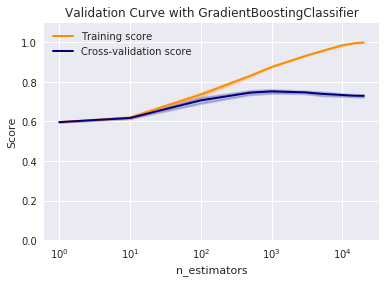

In [63]:
param_range = [1, 10, 100, 500, 1000, 3000, 5000, 10000, 15000, 20000]
train_scores, valid_scores = validation_curve(GradientBoostingClassifier(learning_rate = 0.1,
                      max_depth =  10,
                      min_samples_leaf = 5,
                      max_features = 0.01,
                      max_leaf_nodes =  None), x_train, y_train_cl, "n_estimators",
                                         param_range , n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with GradientBoostingClassifier")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

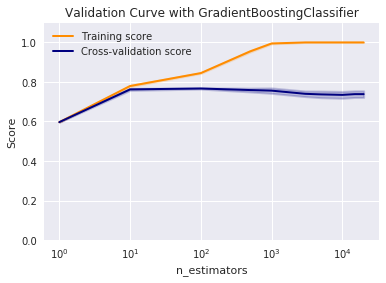

In [64]:
param_range = [1, 10, 100, 500, 1000, 3000, 5000, 10000, 15000, 20000]
train_scores, valid_scores = validation_curve(GradientBoostingClassifier(), x_train, y_train_cl, "n_estimators",
                                         param_range , n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with GradientBoostingClassifier")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")